## Preparation of data

In [19]:
import load_data_multitox as ld
import dataloaders_sigma as dl
from Model_train_test_regression import Net, EarlyStopping, train, test
from visualization import plot_visualization_input_as_parameter, VolToDx

import pandas as pd
import numpy as np

import torch
from torch.utils import data as td
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
from torch.autograd import Variable

import sys 
import os
import glob

from sklearn.model_selection import train_test_split

from tensorboardX import SummaryWriter

import time
from sklearn.preprocessing import MinMaxScaler#StandardScaler

import json


# number of conformers created for every molecule
NUM_CONFS = 100

# amount of chemical elements taking into account
AMOUNT_OF_ELEM = 9

# amount of target values
TARGET_NUM = 29

#dataset folder
# DATASET_PATH="~/Tox21-MultiTox/MultiTox"
DATASET_PATH="./"

#logs path
LOG_PATH_LOAD=os.path.join(DATASET_PATH,"logs_sigma_right")


#models path
MODEL_PATH_LOAD=os.path.join(DATASET_PATH,"models_sigma_right")

In [20]:
EXPERIMENT_NUM=24

In [21]:
args = {}
args['EPOCHS_NUM'] = 100000
args["NUM_EXP"] = EXPERIMENT_NUM
args["LEARN_RATE"] = 1e3          
args["OPTIMIZER"] = 'Adam'
args["WEIGHT_DECAY"] = 1e-1
args["INIT"] = 'noise'
args["TARGET"] = 29

In [22]:
args

{'EPOCHS_NUM': 100000,
 'NUM_EXP': 24,
 'LEARN_RATE': 1000.0,
 'OPTIMIZER': 'Adam',
 'WEIGHT_DECAY': 0.1,
 'INIT': 'noise',
 'TARGET': 29}

In [23]:
LOG_PATH_LOAD = os.path.join(LOG_PATH_LOAD,'exp_'+str(args["NUM_EXP"]))
path = os.path.join(LOG_PATH_LOAD, 'input_backprop')
original_umask = os.umask(0)
os.makedirs(path, mode=0o777, exist_ok=True)
os.umask(original_umask)
LOG_PATH_SAVE = path
path = os.path.join(LOG_PATH_SAVE,'images')
original_umask = os.umask(0)
os.makedirs(path, mode=0o777, exist_ok=True)
os.umask(original_umask)

path = os.path.join(LOG_PATH_SAVE,'pymol')
original_umask = os.umask(0)
os.makedirs(path, mode=0o777, exist_ok=True)
os.umask(original_umask)

path = os.path.join(MODEL_PATH_LOAD,'exp_'+str(args["NUM_EXP"]))
MODEL_PATH_LOAD = path
os.makedirs(path, mode=0o777, exist_ok=True)
os.umask(original_umask)
MODEL_PATH_SAVE = path

with open(os.path.join(LOG_PATH_LOAD,str(args["NUM_EXP"])+'_parameters.json'),'r') as f:
    args_dict = json.load(f)

In [25]:
f_log=open(os.path.join(LOG_PATH_SAVE,str(args["NUM_EXP"])+'_logs.txt'),'w')
f_log.close()
start_time=time.time()
writer=SummaryWriter(LOG_PATH_SAVE)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
with open(os.path.join(LOG_PATH_SAVE,str(args["NUM_EXP"])+'_logs.txt'),'a') as f_log:
    f_log.write('Using device:'+str(device)+'\n')
print()
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

    with open(os.path.join(LOG_PATH_SAVE,str(args["NUM_EXP"])+'_logs.txt'),'a') as f_log:
        f_log.write(torch.cuda.get_device_name(0)+'\n'+'Memory Usage:'+'\n'+'Allocated:'+str(round(torch.cuda.memory_allocated(0)/1024**3,1))+ 'GB'+'\n'+'Cached:   '+str(round(torch.cuda.memory_cached(0)/1024**3,1))+'GB'+'\n')
print('Start loading dataset...')
with open(os.path.join(LOG_PATH_SAVE,str(args["NUM_EXP"])+'_logs.txt'),'a') as f_log:
    f_log.write('Start loading dataset...'+'\n')
# get dataset without duplicates from csv

# create elements dictionary
#     elements = ld.create_element_dict(data, amount=AMOUNT_OF_ELEM+1)
elements={'N':0,'C':1,'Cl':2,'I':3,'Br':4,'F':5,'O':6,'P':7,'S':8}
inv_elems = {v: k for k, v in elements.items()}


Using device: cuda:0

GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Start loading dataset...


In [27]:
# create train and validation sets' indexes
print('Neural network initialization...')
with open(os.path.join(LOG_PATH_SAVE,str(args["NUM_EXP"])+'_logs.txt'),'a') as f_log:
    f_log.write('Neural network initialization...'+'\n') 
if args["INIT"] == 'noise':
    molecule = Variable(torch.randn(1,9,50,50,50).to(device),requires_grad=True)
elif args["INIT"] == 'molecule':
    pass
model = Net(dim=args_dict['VOXEL_DIM'], num_elems=AMOUNT_OF_ELEM, num_targets=TARGET_NUM, elements=elements, transformation=args_dict['TRANSF'],device=device,sigma_0 = args_dict['SIGMA'],sigma_trainable = args_dict['SIGMA_TRAIN'], x_trainable=True, x_input=torch.randn(1,9,50,50,50))
model=model.to(device)
model.load_state_dict(torch.load(os.path.join(MODEL_PATH_LOAD,'checkpoint.pt')))
model.x_input=Parameter(molecule,requires_grad=True)

Neural network initialization...


In [29]:
if args["TARGET"] == -1:
    target = torch.zeros(29)
elif args["TARGET"] == 29:
    target = torch.ones(1,29)
elif args["TARGET"]>=0 and args["TARGET"]<29:
    target = torch.tensor(1.0)
#     target=torch.tensor(1.0)

target = target.to(device)



with open(os.path.join(LOG_PATH_SAVE,str(args["NUM_EXP"])+'_parameters.json'),'w') as f:
    json.dump(args, f)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    print ('Run in parallel!')
    with open(os.path.join(LOG_PATH_SAVE,str(args["NUM_EXP"])+'_logs.txt'),'a') as f_log:
        f_log.write('Run in parallel!'+'\n')

# Construct our model by instantiating the class defined above

model=model.to(device)

for name, param in model.named_parameters():
    print(name, type(param.data), param.size())
# set optimizer
if args["OPTIMIZER"] == 'Adam':
    optimizer = torch.optim.Adam([model.x_input], lr=args["LEARN_RATE"], weight_decay=args["WEIGHT_DECAY"])
elif args["OPTIMIZER"] == 'SGDL2':
    optimizer = torch.optim.SGD([model.x_input], lr=args["LEARN_RATE"])


print('Neural network has been initialized, ', int(time.time()-start_time),' s')
with open(os.path.join(LOG_PATH_SAVE,str(args["NUM_EXP"])+'_logs.txt'),'a') as f_log:
        f_log.write('Neural network has been initialized\n')

x_input <class 'torch.Tensor'> torch.Size([1, 9, 50, 50, 50])
conv1.weight <class 'torch.Tensor'> torch.Size([32, 9, 3, 3, 3])
conv1.bias <class 'torch.Tensor'> torch.Size([32])
conv2.weight <class 'torch.Tensor'> torch.Size([64, 32, 3, 3, 3])
conv2.bias <class 'torch.Tensor'> torch.Size([64])
conv3.weight <class 'torch.Tensor'> torch.Size([128, 64, 3, 3, 3])
conv3.bias <class 'torch.Tensor'> torch.Size([128])
conv4.weight <class 'torch.Tensor'> torch.Size([256, 128, 3, 3, 3])
conv4.bias <class 'torch.Tensor'> torch.Size([256])
fc1.weight <class 'torch.Tensor'> torch.Size([128, 256])
fc1.bias <class 'torch.Tensor'> torch.Size([128])
fc2.weight <class 'torch.Tensor'> torch.Size([29, 128])
fc2.bias <class 'torch.Tensor'> torch.Size([29])
Neural network has been initialized,  240  s


In [76]:
def plot_visualization_input_as_parameter(model,elements,losses, epoch):
    import matplotlib.pyplot as plt
    inv_elems = {v: k for k, v in elements.items()}    
    data=model.x_input
    molecules = data.cpu().detach().sum(dim=0)
    fig = plt.figure(figsize=(10,15),constrained_layout=True)
    gs = fig.add_gridspec(4, 3)
    for i,grad in enumerate(molecules):
        f_ax = fig.add_subplot(gs[i//3,i%3])
        f_ax.imshow(grad.sum(dim=0))
        f_ax.set_title(inv_elems[i],fontsize=25)
    f_ax = fig.add_subplot(gs[-1, :])
    f_ax.plot(5*np.arange(0,len(losses),1),losses)
    f_ax.set_title('Loss function',fontsize=25)
    f_ax.set_xlabel('epochs',fontsize=25)
    f_ax.set_ylabel('loss',fontsize=25)
    fig.suptitle('Atom types in molecule',fontsize=25)
    
    plt.show()
    fig.savefig(os.path.join(LOG_PATH_SAVE,'images','img_'+str(epoch))+'.png',dpi=150,format='png')
    _ = plt.clf()
    
    

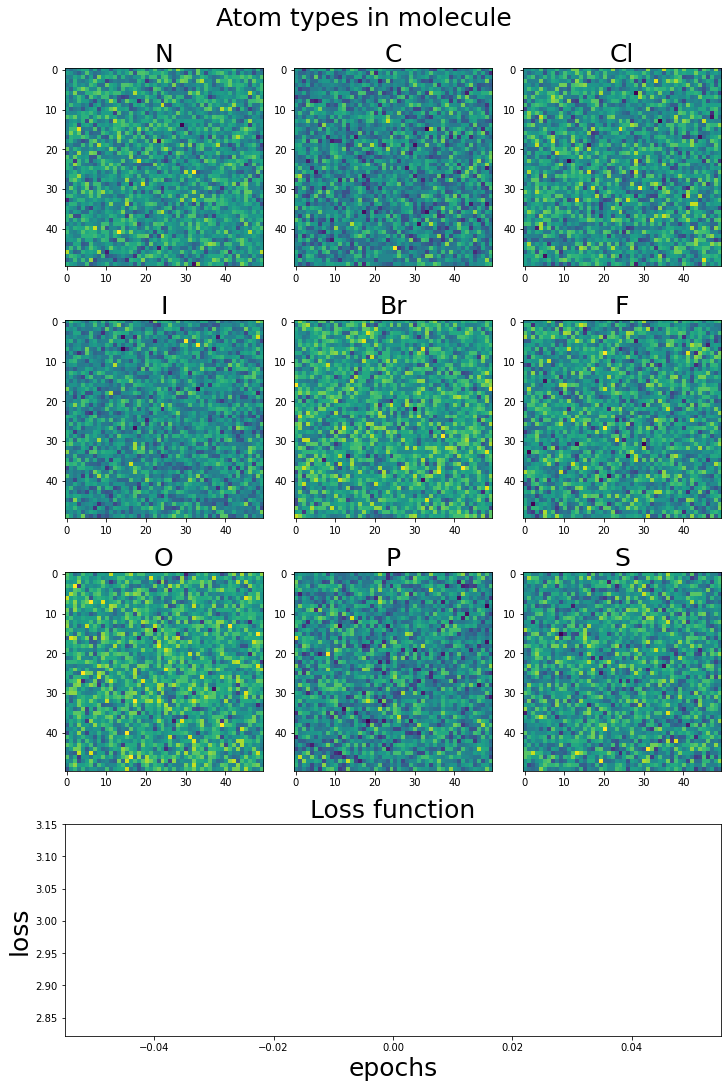

In [ ]:
losses = []
for epoch in range(args["EPOCHS_NUM"]):
    output = model(model.x_input)
    criterion=nn.MSELoss()
    if args["TARGET"]>=0 and args["TARGET"]<29:
        loss = criterion(output[args["TARGET"]], target)
    else:
        loss = criterion(output, target)
    model.zero_grad()
    loss.backward()
    writer.add_scalar('Loss/', loss.cpu().detach().numpy().item(), epoch)
    optimizer.step()
    
    if epoch%5==0:
        losses.append(loss.cpu().detach().numpy().item())
        plot_visualization_input_as_parameter(model,elements,losses, epoch)
        for element in elements:
            s = VolToDx()(**{'volume':model.x_input.cpu().detach()[0,elements[element],:,:,:].squeeze().numpy(),'origin':np.array([-17.5,-17.5,-17.5]),'dsteps':np.array([0.5,0.5,0.5])})
            with open(os.path.join(LOG_PATH_SAVE,'pymol',element+'_pymol_'+str(epoch)+'.dx'),'w') as f:
                f.write(s)
        s = VolToDx()(**{'volume':model.x_input.cpu().detach()[0,:,:,:,:].squeeze().numpy().sum(axis=0),'origin':np.array([-17.5,-17.5,-17.5]),'dsteps':np.array([0.5,0.5,0.5])})
        with open(os.path.join(LOG_PATH_SAVE,'pymol','pymol_'+str(epoch)+'.dx'),'w') as f:
            f.write(s)
    if epoch %100==0 and epoch>5000:
        torch.save(model.state_dict(),os.path.join(MODEL_PATH_SAVE,'model_'+str(epoch)+'.pt'))

model.load_state_dict(torch.load(os.path.join(MODEL_PATH_SAVE,'checkpoint.pt')))
torch.save(model.state_dict(), os.path.join(MODEL_PATH_SAVE, args.NUM_EXP+'_model'+str(epoch)+'_fin'))
f_train_loss.close()
writer.close()

## Visualization function